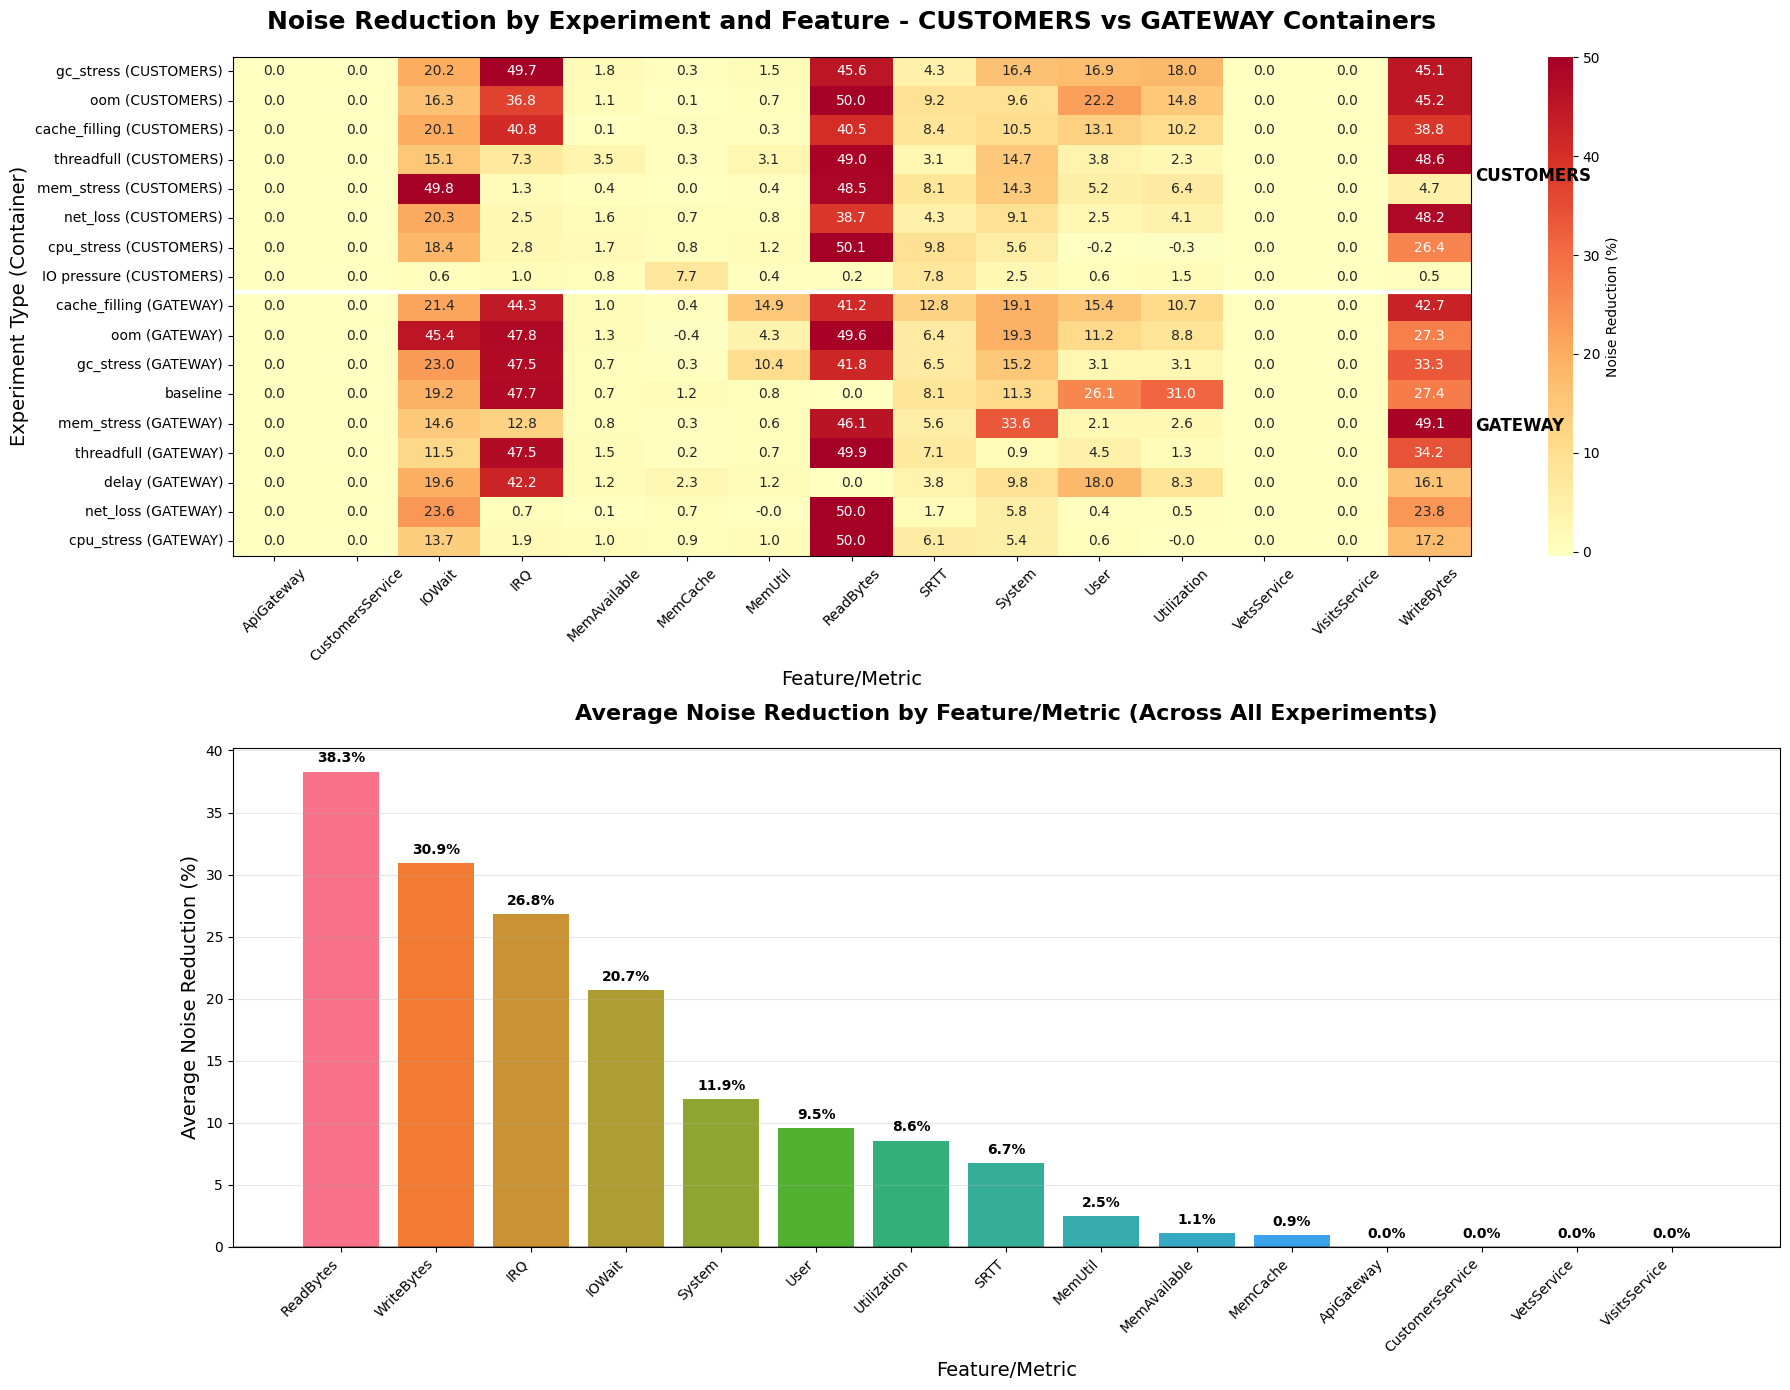

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import numpy as np

data_dir = "."  

def load_all_tuna_data(directory):
    """Load all TUNA CSV files from directory"""
    csv_files = glob.glob(os.path.join(directory, "*.csv"))
    all_data = []
    
    for file_path in csv_files:
        try:
            df = pd.read_csv(file_path)
            filename = os.path.basename(file_path).replace('.csv', '')
            df['source_file'] = filename
            all_data.append(df)
        except Exception as e:
            pass
    
    if all_data:
        return pd.concat(all_data, ignore_index=True)
    return None

# Load data
df_all = load_all_tuna_data(data_dir)

if df_all is not None:
    # Clean data
    df_clean = df_all.dropna(subset=['experiment_name', 'metric', 'noise_reduction_pct'])
    df_clean['noise_reduction_pct'] = pd.to_numeric(df_clean['noise_reduction_pct'], errors='coerce')
    
    def extract_container(filename):
        if 'customers' in filename.lower():
            return 'customers'
        elif 'gateway' in filename.lower():
            return 'gateway'
        else:
            return 'unknown'
    
    df_clean['container'] = df_clean['source_file'].apply(extract_container)
    
    # Remove unknown containers
    df_clean = df_clean[df_clean['container'] != 'unknown']
    
    # Filter out baseline customers - keep only baseline gateway
    df_clean = df_clean[~((df_clean['experiment_name'].str.contains('baseline', case=False)) & 
                          (df_clean['container'] == 'customers'))]
    
    # Create combined experiment_container labels
    df_clean['experiment_container'] = df_clean['experiment_name'] + ' (' + df_clean['container'].str.upper() + ')'
    
    # Rename baseline gateway to just 'baseline'
    df_clean.loc[df_clean['experiment_container'].str.contains('baseline.*GATEWAY', case=False), 'experiment_container'] = 'baseline'
    
    # Create pivot table for combined heatmap
    pivot_data_combined = df_clean.pivot_table(
        values='noise_reduction_pct', 
        index='experiment_container', 
        columns='metric', 
        aggfunc='mean'
    )
    
    # Sort by container and then by experiment performance
    customers_experiments = [idx for idx in pivot_data_combined.index if 'CUSTOMERS' in idx]
    gateway_experiments = [idx for idx in pivot_data_combined.index if 'GATEWAY' in idx or idx == 'baseline']
    
    # Sort each container group by average performance
    customers_avg = pivot_data_combined.loc[customers_experiments].mean(axis=1).sort_values(ascending=False)
    gateway_avg = pivot_data_combined.loc[gateway_experiments].mean(axis=1).sort_values(ascending=False)
    
    # Combine the sorted order
    ordered_index = list(customers_avg.index) + list(gateway_avg.index)
    pivot_data_ordered = pivot_data_combined.reindex(ordered_index)
    
    # Create subplots: heatmap and histogram
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 14))
    
    # 1. Combined heatmap
    sns.heatmap(pivot_data_ordered, 
                annot=True, 
                fmt='.1f', 
                cmap='RdYlBu_r', 
                center=0, 
                ax=ax1,
                cbar_kws={'label': 'Noise Reduction (%)'})
    
    ax1.set_title('Noise Reduction by Experiment and Feature - CUSTOMERS vs GATEWAY Containers', 
                 fontsize=18, fontweight='bold', pad=20)
    ax1.set_xlabel('Feature/Metric', fontsize=14)
    ax1.set_ylabel('Experiment Type (Container)', fontsize=14)
    
    # Fix the axis labels rotation
    ax1.tick_params(axis='x', rotation=45)
    ax1.tick_params(axis='y', rotation=0)  # Make y-axis labels horizontal
    
    # Add a subtle separator line between containers
    customers_count = len(customers_experiments)
    if customers_count > 0:
        ax1.axhline(y=customers_count, color='white', linewidth=3)
    
    # Add container group labels on the right
    ax1_twin = ax1.twinx()
    ax1_twin.set_ylim(ax1.get_ylim())
    ax1_twin.set_yticks([customers_count/2, customers_count + len(gateway_experiments)/2])
    ax1_twin.set_yticklabels(['CUSTOMERS', 'GATEWAY'], fontsize=12, fontweight='bold')
    ax1_twin.tick_params(axis='y', length=0)  # Remove tick marks
    
    # 2. Feature performance histogram
    feature_performance = df_clean.groupby('metric')['noise_reduction_pct'].mean().sort_values(ascending=False)
    
    bars = ax2.bar(range(len(feature_performance)), feature_performance.values, 
                   color=sns.color_palette("husl", len(feature_performance)))
    
    ax2.set_title('Average Noise Reduction by Feature/Metric (Across All Experiments)', 
                  fontsize=16, fontweight='bold', pad=20)
    ax2.set_xlabel('Feature/Metric', fontsize=14)
    ax2.set_ylabel('Average Noise Reduction (%)', fontsize=14)
    ax2.set_xticks(range(len(feature_performance)))
    ax2.set_xticklabels(feature_performance.index, rotation=45, ha='right')
    ax2.grid(axis='y', alpha=0.3)
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars, feature_performance.values):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + (0.5 if height >= 0 else -1.5),
                f'{value:.1f}%', ha='center', va='bottom' if height >= 0 else 'top',
                fontweight='bold', fontsize=10)
    
    plt.tight_layout()
    plt.show()

else:
    pass

#TODO. REMOVE THE BASELINE SINGLE
# remember the tcp hack!!